# Creating the new grid where only the top cell is changed

This code creates a new vertical grid for the experiment 5mtop, where the difference from 5mdz is that only the topmost cell was changes to have 5m depth.

In [1]:
import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import IPython.display

Grids are

In [2]:
#KDS75 original grid for panan01
Vcoord=xr.open_dataset('/g/data/ik11/inputs/mom6/panan-01/vcoord.nc')
hycom1_75=xr.open_dataset('/g/data/ik11/inputs/mom6/panan-01/hycom1_75_800m.nc')
hycom1_panan=xr.open_dataset('/g/data/ik11/inputs/mom6/panan-01/hycom1_panant.nc')


### Part 1- Changes in _vcoord_ file

In [3]:
top_KDS75=Vcoord.st_edges_ocean[0:-1]
centre_KDS75=Vcoord.st_ocean
bottom_KDS75=Vcoord.st_edges_ocean[1:]

Making the new 5mtop cell grid:

In [4]:
#It will be equal from the 3rd index down
bottom_5mtop=bottom_KDS75[3:]
centre_5mtop=centre_KDS75[3:]*0
top_5mtop=top_KDS75.isel(st_edges_ocean=np.r_[0, 4:75])


centre_5mtop[0]=bottom_5mtop[0].values/2
centre_5mtop[1:]=centre_KDS75[4:].values

How do they look?

Text(0.5, 1.0, '[c] Centre of cells')

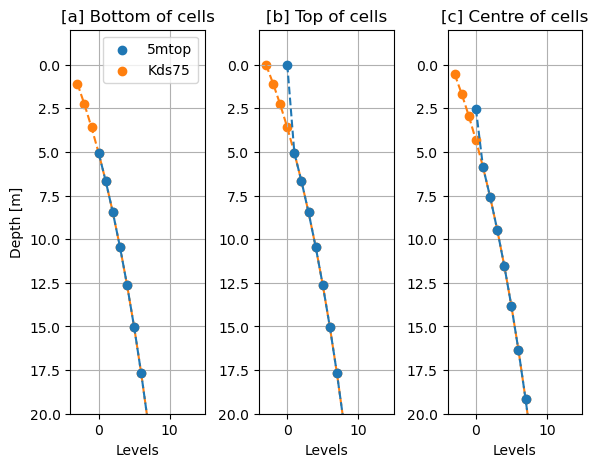

In [5]:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(1,3,1)
plt.scatter(range(72),bottom_5mtop,label='5mtop',zorder=3)
plt.plot(range(72),bottom_5mtop,color='tab:blue',linestyle='--',zorder=4)

plt.scatter(np.arange(75)-3,bottom_KDS75,label='Kds75')
plt.plot(np.arange(75)-3,bottom_KDS75,color='tab:orange',linestyle='--')


plt.ylim(20,-2); plt.grid(); plt.legend(); plt.xlim(-4,15)
plt.ylabel('Depth [m]'); plt.xlabel('Levels');
plt.title('[a] Bottom of cells')


plt.subplot(1,3,2)
plt.scatter(range(72),top_5mtop,label='5mtop',zorder=3)
plt.plot(range(72),top_5mtop,color='tab:blue',linestyle='--',zorder=4)

plt.scatter(np.arange(75)-3,top_KDS75,label='Kds75')
plt.plot(np.arange(75)-3,top_KDS75,color='tab:orange',linestyle='--')


plt.ylim(20,-2); plt.grid(); plt.xlim(-4,15)
plt.xlabel('Levels');
plt.title('[b] Top of cells')


plt.subplot(1,3,3)
plt.scatter(range(72),centre_5mtop,label='5mtop',zorder=3)
plt.plot(range(72),centre_5mtop,color='tab:blue',linestyle='--',zorder=4)

plt.scatter(np.arange(75)-3,centre_KDS75,label='Kds75')
plt.plot(np.arange(75)-3,centre_KDS75,color='tab:orange',linestyle='--')


plt.ylim(20,-2); plt.grid(); plt.xlim(-4,15)
plt.xlabel('Levels');
plt.title('[c] Centre of cells')

It seems like the cells are correctly placed

lets create the new grid file

In [6]:
# the new vlues for vcood file would be
st_edges_ocean_5mtop = bottom_KDS75[2:]*0
st_edges_ocean_5mtop[1:] = bottom_KDS75[3:]
st_edges_ocean_5mtop[0] = top_5mtop[0]
st_ocean_5mtop = centre_5mtop

In [7]:
#new vcood will 
outputdir= '/home/156/wf4500/v45_wf4500/DSW_collaborative/panan01_run/mom6-panan/local_input/'
Vcoord_5mtop =  Vcoord.isel(st_ocean=slice(3,75)).isel(st_edges_ocean=slice(3,76))
Vcoord_5mtop['st_edges_ocean']=(Vcoord_5mtop['st_edges_ocean']*0) + st_edges_ocean_5mtop
Vcoord_5mtop['st_ocean'] = (Vcoord_5mtop['st_ocean']*0) + st_ocean_5mtop
#Vcoord_5mtop.to_netcdf(outputdir + 'vcoord.nc')

Now, lets create the new zeta, which will be

### Part 2 - change _hycom1_75_

In [8]:
hycom1_5mtop=hycom1_75.isel(layers=slice(3,75))
#Changing top cell thickness to 5 meters
hycom1_5mtop['dz'][0]= 5
hycom1_5mtop.dz

<xarray.DataArray 'dz' (layers: 72)>
[72 values with dtype=float64]
Dimensions without coordinates: layers
Attributes:
    long_name:  z* coordinate level thickness
    units:      m

In [9]:
#hycom1_pana file
hycom1_panan_5mtop=hycom1_panan.isel(layers=slice(3,75))
hycom1_panan_5mtop['dz'][0]= 5
hycom1_panan_5mtop

<xarray.Dataset>
Dimensions:  (layers: 72, interfaces: 76)
Dimensions without coordinates: layers, interfaces
Data variables:
    dz       (layers) float64 ...
    sigma2   (interfaces) float64 ...

In [10]:
# Saving files
#hycom1_5mtop.to_netcdf(outputdir + 'hycom1_72_800m.nc')
#hycom1_panan_5mtop.to_netcdf(outputdir + 'hycom1_panant.nc')

## Additional step: Creating the new TS initial conditions for 5mtop run



In [11]:
import netCDF4
import xesmf as xe
from itertools import cycle
import os
import dask
import IPython.display
import pandas as pd
import dask.array as da
import dask.bag as db
from pykdtree.kdtree import KDTree
from dask.diagnostics import ProgressBar
import subprocess
from glob import glob

import logging
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

xr.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 21,Total memory: 765.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38135,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 21
Started: Just now,Total memory: 765.00 GiB
Comm: tcp://127.0.0.1:43935,Total threads: 3
Dashboard: /proxy/39017/status,Memory: 109.29 GiB
Nanny: tcp://127.0.0.1:33639,


Importing the original IC for panan01, with 75 levels.

In [12]:
MOM6_temp  = xr.open_dataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/panan01_run/mom6-panan/local_input/forcing/ACCESS-OM2_pottemp_salt_yr2.nc').temp
MOM6_salt  = xr.open_dataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/panan01_run/mom6-panan/local_input/forcing/ACCESS-OM2_pottemp_salt_yr2.nc').salt

data_in = xr.Dataset({'temp': MOM6_temp,'salt':MOM6_salt})

Notice that the targer grid file below differs from the one created above, because we ran the float_vgrid tool from topogtools, to fix the double precision of the grid.

In [13]:
# target grid (t points)

dg = xr.open_dataset(outputdir + 'vcoord.nc') #the new vgrid
dg = (
    dg[["st_ocean"]]
    .rename(st_ocean="depth")
)


outgrid = data_in.drop_vars('temp').drop_vars('salt').drop_vars('depth')

outgrid['depth']=dg['depth']
outgrid

<xarray.Dataset>
Dimensions:  (nxp: 3600, nyp: 845, depth: 72)
Coordinates:
  * nxp      (nxp) float64 -280.0 -279.9 -279.8 -279.7 ... 79.72 79.82 79.92
  * nyp      (nyp) float64 -81.1 -81.06 -81.01 -80.97 ... -37.28 -37.2 -37.12
  * depth    (depth) float64 2.531 5.869 7.569 ... 5.313e+03 5.511e+03 5.709e+03
Data variables:
    *empty*

In [14]:
#grids for xarray interp
lon=outgrid['nxp']
lat=outgrid['nyp']
zout=outgrid['depth']
zin=data_in['depth']

In [15]:
data_out=data_in.interp(nxp=lon,nyp=lat,depth=zout)

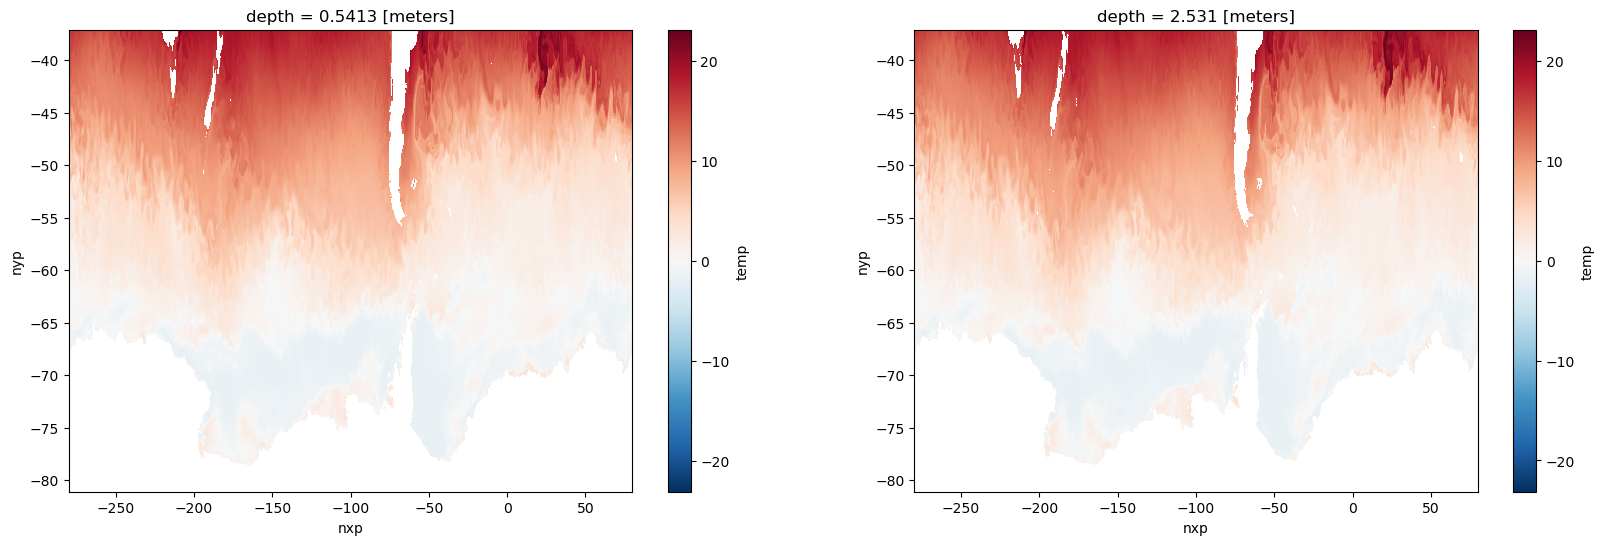

In [16]:
#plotting data - surface temp
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
#input data
data_in['temp'].isel(depth=0).plot(ax=ax1)
#output data
data_out['temp'].isel(depth=0).plot(ax=ax2)

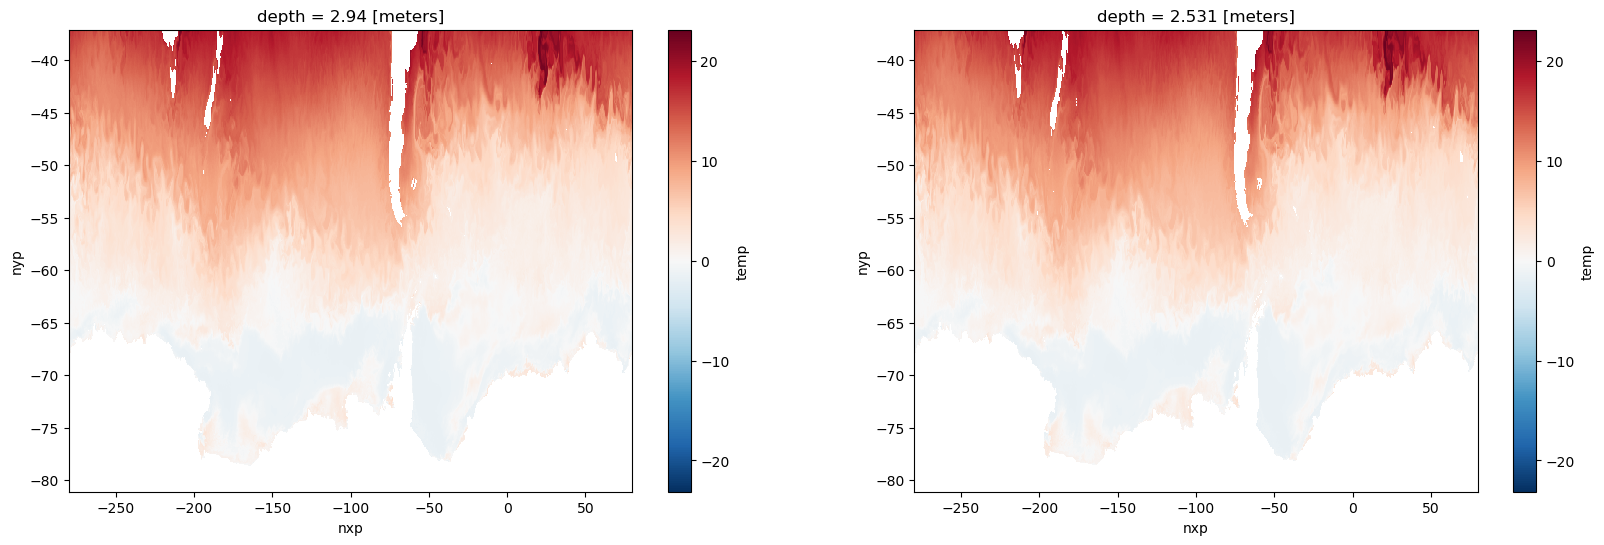

In [17]:
#plotting data - surface temp in out, 3rd layer in in
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
#input data
data_in['temp'].isel(depth=2).plot(ax=ax1)
#output data
data_out['temp'].isel(depth=0).plot(ax=ax2)

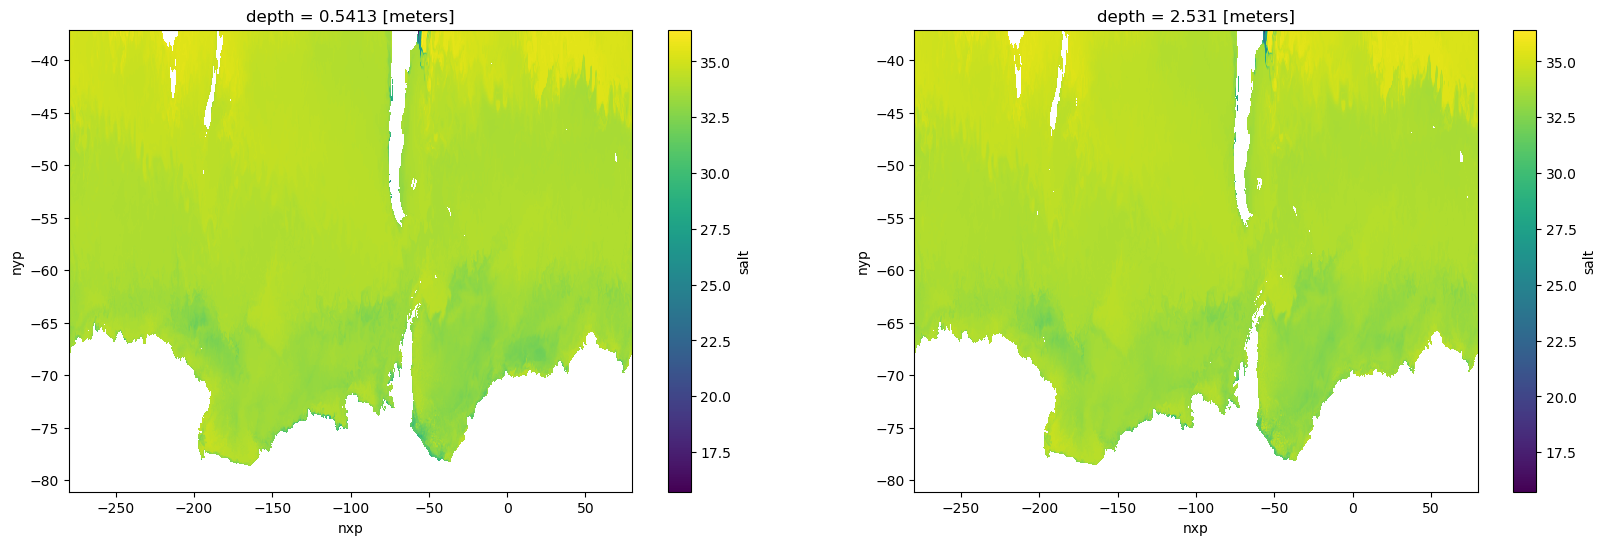

In [18]:
#plotting data - surface Salinity
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
#input data
data_in['salt'].isel(depth=0).plot(ax=ax1)
#output data
data_out['salt'].isel(depth=0).plot(ax=ax2)

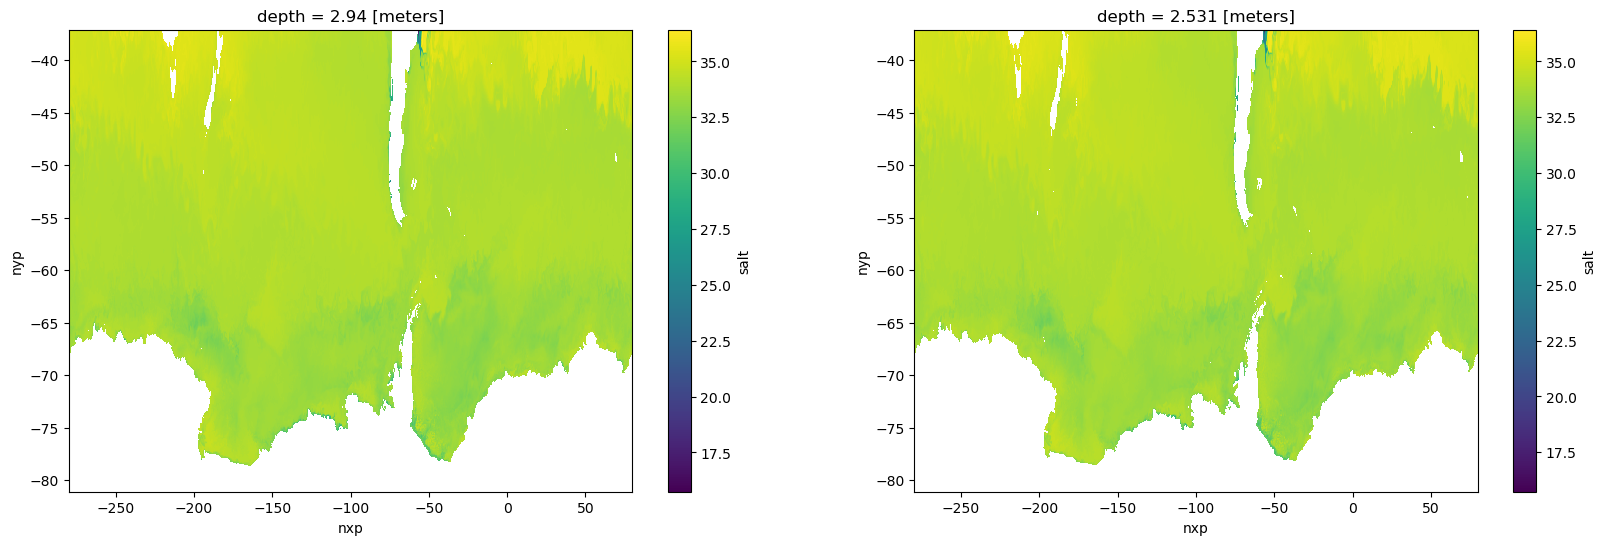

In [19]:
#plotting data - surface Salinity
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
#input data
data_in['salt'].isel(depth=2).plot(ax=ax1)
#output data
data_out['salt'].isel(depth=0).plot(ax=ax2)

scatter plots for the surface salinity and temperature to check of they are correct and or make sense

In [20]:
#max salinities between grids
data_in.salt.isel(depth=0).max().values, data_out.salt.isel(depth=0).max().values

(array(36.4202919), array(36.42013139))

In [21]:
#min salinities between grids
data_in.salt.isel(depth=0).min().values, data_out.salt.isel(depth=0).min().values

(array(15.72433376), array(15.73608645))

In [22]:
#max temperature between grids
data_in.temp.isel(depth=0).max().values, data_out.temp.isel(depth=0).max().values

(array(23.11520386), array(23.13108649))

In [23]:
#min temperature between grids
data_in.temp.isel(depth=0).min().values, data_out.temp.isel(depth=0).min().values

(array(-1.80502319), array(-1.80494312))

Text(0, 0.5, 'regridded 2.5m')

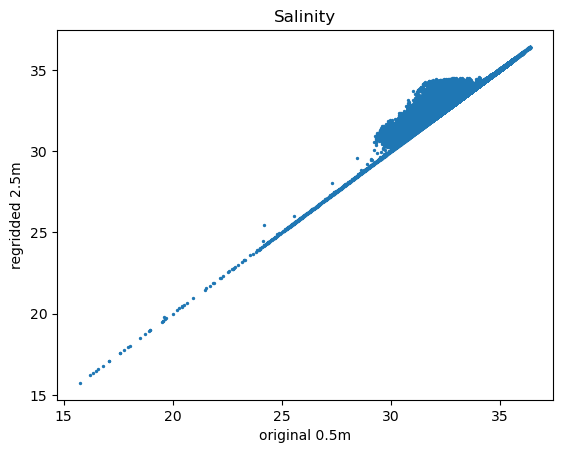

In [24]:
plt.scatter(data_in.salt.isel(depth=0),data_out.salt.isel(depth=0),s=2)
plt.title('Salinity')
plt.xlabel('original 0.5m')
plt.ylabel('regridded 2.5m')

Text(0, 0.5, 'regridded 2.5m')

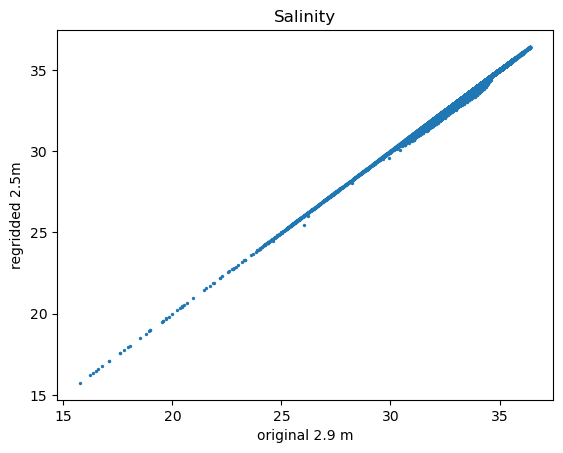

In [25]:
plt.scatter(data_in.salt.isel(depth=2),data_out.salt.isel(depth=0),s=2)
plt.title('Salinity')
plt.xlabel('original 2.9 m')
plt.ylabel('regridded 2.5m')

Text(0, 0.5, 'regridded 2.5m')

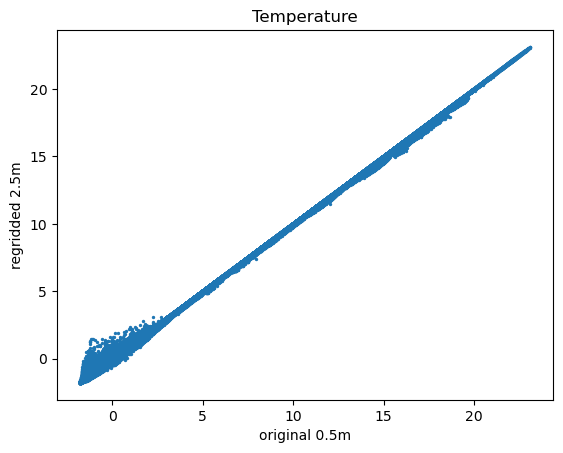

In [26]:
plt.scatter(data_in.temp.isel(depth=0),data_out.temp.isel(depth=0),s=2)
plt.title('Temperature')
plt.xlabel('original 0.5m')
plt.ylabel('regridded 2.5m')

Text(0, 0.5, 'regridded 2.5m')

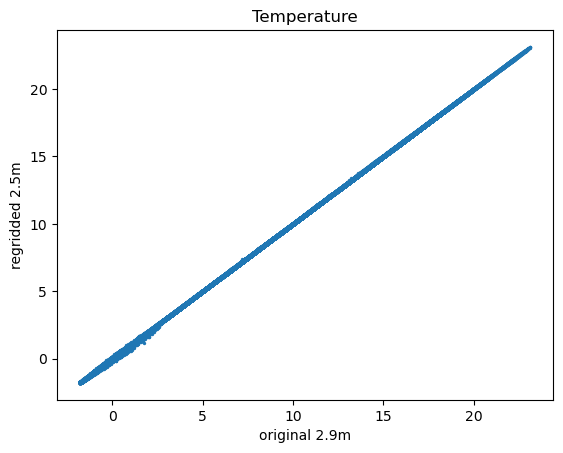

In [27]:
plt.scatter(data_in.temp.isel(depth=2),data_out.temp.isel(depth=0),s=2)
plt.title('Temperature')
plt.xlabel('original 2.9m')
plt.ylabel('regridded 2.5m')

Saving files

In [28]:
#saving
enc = {
    "_FillValue": -1.e+34
}

# Make them doubles:
data_out['temp'] = data_out['temp'].astype('double')
data_out['salt'] = data_out['salt'].astype('double')


#data_out.to_netcdf("/home/156/wf4500/v45_wf4500/DSW_collaborative/local_input/forcing/" +"ACCESS-OM2_pottemp_salt_yr2.nc", encoding={"temp": enc, "salt": enc})



In [29]:
np.single(data_out.depth[0])

2.5310228

### Part 3  - Boundary conditions

In [82]:
#Importing it
MOM6_boundary  = xr.open_dataset('/home/156/wf4500/v45_wf4500/DSW_collaborative/panan01_run/mom6-panan/local_input/forcing/forcing_access_yr2_01.nc')


Notice nz that depth in this matrix is not actual depth, but level number. So for this interpoaltion I will have too..

1- first substitute the nzs for depth on oridinal data (MOM6_boundary)

2- Interpoalte into the new depth range with 72 layers

3- Replace back the nzs into in32 indexes


... and then think of what to do  with dzs.
                           

In [84]:
MOM6_boundary_z=MOM6_boundary.copy()
MOM6_boundary_z['nz_segment_001_pot_temp']=centre_KDS75.st_ocean.rename({"st_ocean":"nz_segment_001_pot_temp"})
MOM6_boundary_z['nz_segment_001_salt']=centre_KDS75.st_ocean.rename({"st_ocean":"nz_segment_001_salt"})
MOM6_boundary_z['nz_segment_001_u']=centre_KDS75.st_ocean.rename({"st_ocean":"nz_segment_001_u"})
MOM6_boundary_z['nz_segment_001_v']=centre_KDS75.st_ocean.rename({"st_ocean":"nz_segment_001_v"})

In [85]:
# nz_segment_001_pot_temp
MOM6_boundary_z2 = MOM6_boundary_z.interp(nz_segment_001_pot_temp=Vcoord_5mtop.st_ocean.rename({"st_ocean":"nz_segment_001_pot_temp"}))


In [86]:
# nz_segment_001_salt
MOM6_boundary_z2=MOM6_boundary_z2.interp(nz_segment_001_salt=Vcoord_5mtop.st_ocean.rename({"st_ocean":"nz_segment_001_salt"}))



In [87]:
# nz_segment_001_v
MOM6_boundary_z2 = MOM6_boundary_z2.interp(nz_segment_001_v=Vcoord_5mtop.st_ocean.rename({"st_ocean":"nz_segment_001_v"}))


In [88]:
# nz_segment_001_u
MOM6_boundary_z2 =  MOM6_boundary_z2.interp(nz_segment_001_u=Vcoord_5mtop.st_ocean.rename({"st_ocean":"nz_segment_001_u"}))


Comparisson of patterns

Text(0.5, 1.0, 'Original')

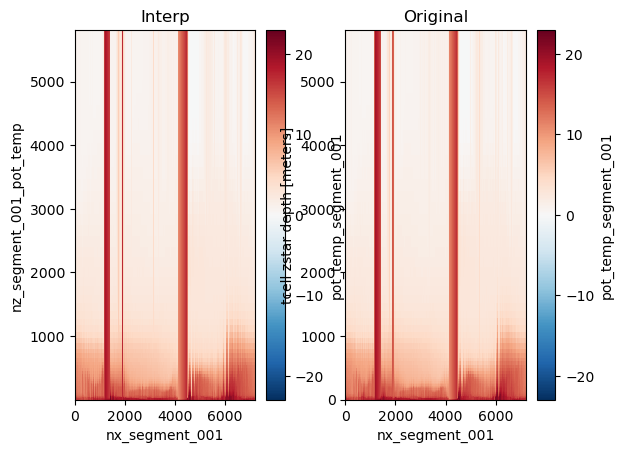

In [89]:
plt.subplot(1,2,1)
MOM6_boundary_z2.pot_temp_segment_001.isel(ny_segment_001=0,time=0).plot()
plt.title('Interp')

plt.subplot(1,2,2)
MOM6_boundary_z.pot_temp_segment_001.isel(ny_segment_001=0,time=0).plot()
plt.title('Original')

Lets now create the MOM6_boundary2 matrix, from MOM6_boundary_z2, but reinstating the Nz's as in32 indexes.

In [95]:
MOM6_boundary2= MOM6_boundary_z2.copy()
MOM6_boundary2["nz_segment_001_v"] = np.arange(0, 72, dtype='int32')
MOM6_boundary2["nz_segment_001_u"] = np.arange(0, 72, dtype='int32')
MOM6_boundary2["nz_segment_001_salt"] = np.arange(0, 72, dtype='int32')
MOM6_boundary2["nz_segment_001_pot_temp"] = np.arange(0, 72, dtype='int32')

Now for the DZ. we can't just interpolate this. However, the only difference between the case with 75 levels, and the case with 72 levels, comes from the first cell. Specifically, the bottom of the _Vcoord.st_ocean[4]_ is approximately the same bottom of the cell _Vcoord_5mtop.st_ocean[1]_. Therefore, we can just sume the thicknesses of the top 4 for cells in MOM6_boundary, and attribute the resulting sum to the thickness of MOM6_boundary_z2. 

creating the nz segments...

In [167]:
#dz_u
dz_u_segment_001_new=np.zeros(np.shape(MOM6_boundary2.dz_u_segment_001),dtype='float64')
dz_u_segment_001_new[:,0,:,:]=MOM6_boundary.dz_u_segment_001.isel(nz_segment_001_u=slice(0,4)).sum('nz_segment_001_u')
dz_u_segment_001_new[:,1:,:,:]=MOM6_boundary.dz_u_segment_001.isel(nz_segment_001_u=slice(4,75))
dz_u_segment_001_new=xr.DataArray(dz_u_segment_001_new,dims=["time","nz_segment_001_u","ny_segment_001","nx_segment_001"])
dz_u_segment_001_new["time"]=MOM6_boundary2.time
dz_u_segment_001_new["nz_segment_001_u"]=MOM6_boundary2.nz_segment_001_u
dz_u_segment_001_new["ny_segment_001"]=MOM6_boundary2.ny_segment_001
dz_u_segment_001_new["nx_segment_001"]=MOM6_boundary2.nx_segment_001

#dz_v
dz_v_segment_001_new=np.zeros(np.shape(MOM6_boundary2.dz_v_segment_001),dtype='float64')
dz_v_segment_001_new[:,0,:,:]=MOM6_boundary.dz_v_segment_001.isel(nz_segment_001_v=slice(0,4)).sum('nz_segment_001_v')
dz_v_segment_001_new[:,1:,:,:]=MOM6_boundary.dz_v_segment_001.isel(nz_segment_001_v=slice(4,75))
dz_v_segment_001_new=xr.DataArray(dz_v_segment_001_new,dims=["time","nz_segment_001_v","ny_segment_001","nx_segment_001"])
dz_v_segment_001_new["time"]=MOM6_boundary2.time
dz_v_segment_001_new["nz_segment_001_v"]=MOM6_boundary2.nz_segment_001_v
dz_v_segment_001_new["ny_segment_001"]=MOM6_boundary2.ny_segment_001
dz_v_segment_001_new["nx_segment_001"]=MOM6_boundary2.nx_segment_001


#dz_pot_temp
dz_pot_temp_segment_001_new=np.zeros(np.shape(MOM6_boundary2.dz_pot_temp_segment_001),dtype='float64')
dz_pot_temp_segment_001_new[:,0,:,:]=MOM6_boundary.dz_pot_temp_segment_001.isel(nz_segment_001_pot_temp=slice(0,4)).sum('nz_segment_001_pot_temp')
dz_pot_temp_segment_001_new[:,1:,:,:]=MOM6_boundary.dz_pot_temp_segment_001.isel(nz_segment_001_pot_temp=slice(4,75))
dz_pot_temp_segment_001_new=xr.DataArray(dz_pot_temp_segment_001_new,dims=["time","nz_segment_001_pot_temp","ny_segment_001","nx_segment_001"])
dz_pot_temp_segment_001_new["time"]=MOM6_boundary2.time
dz_pot_temp_segment_001_new["nz_segment_001_pot_temp"]=MOM6_boundary2.nz_segment_001_pot_temp
dz_pot_temp_segment_001_new["ny_segment_001"]=MOM6_boundary2.ny_segment_001
dz_pot_temp_segment_001_new["nx_segment_001"]=MOM6_boundary2.nx_segment_001


#dz_salt
dz_salt_segment_001_new=np.zeros(np.shape(MOM6_boundary2.dz_salt_segment_001),dtype='float64')
dz_salt_segment_001_new[:,0,:,:]=MOM6_boundary.dz_salt_segment_001.isel(nz_segment_001_salt=slice(0,4)).sum('nz_segment_001_salt')
dz_salt_segment_001_new[:,1:,:,:]=MOM6_boundary.dz_salt_segment_001.isel(nz_segment_001_salt=slice(4,75))
dz_salt_segment_001_new=xr.DataArray(dz_salt_segment_001_new,dims=["time","nz_segment_001_salt","ny_segment_001","nx_segment_001"])
dz_salt_segment_001_new["time"]=MOM6_boundary2.time
dz_salt_segment_001_new["nz_segment_001_salt"]=MOM6_boundary2.nz_segment_001_salt
dz_salt_segment_001_new["ny_segment_001"]=MOM6_boundary2.ny_segment_001
dz_salt_segment_001_new["nx_segment_001"]=MOM6_boundary2.nx_segment_001

In [168]:
#replacing values on final xarray
MOM6_boundary2["dz_u_segment_001"]=dz_u_segment_001_new
MOM6_boundary2["dz_v_segment_001"]=dz_v_segment_001_new
MOM6_boundary2["dz_salt_segment_001"]=dz_salt_segment_001_new
MOM6_boundary2["dz_pot_temp_segment_001"]=dz_pot_temp_segment_001_new

Is the output correct? Let's check it

(10.0, 0.0)

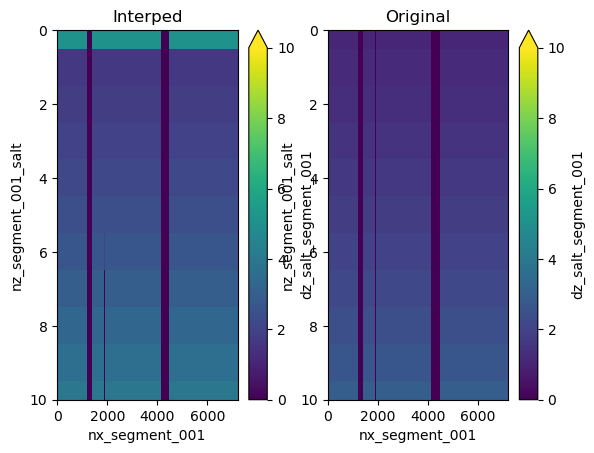

In [187]:
plt.subplot(1,2,1)
MOM6_boundary2.dz_salt_segment_001.isel(time=100,ny_segment_001=0).plot(vmin=0,vmax=10)
plt.title('Interped'); plt.ylim(10,0);

plt.subplot(1,2,2)
MOM6_boundary.dz_salt_segment_001.isel(time=100,ny_segment_001=0).plot(vmin=0,vmax=10)
plt.title('Original'); plt.ylim(10,0)

It seems correct, since in the interped data, the top cell has ~5m thickness, and locations without dz (dz=0) are maintained. LEt's save the data..


In [192]:
MOM6_boundary2

<xarray.Dataset>
Dimensions:                  (time: 365, nx_segment_001: 7201,
                              ny_segment_001: 1, nz_segment_001_pot_temp: 72,
                              nz_segment_001_salt: 72, nz_segment_001_u: 72,
                              nz_segment_001_v: 72)
Coordinates:
  * time                     (time) object 1900-01-01 12:00:00 ... 1900-12-31...
  * nx_segment_001           (nx_segment_001) int32 0 1 2 3 ... 7198 7199 7200
  * ny_segment_001           (ny_segment_001) int32 0
  * nz_segment_001_pot_temp  (nz_segment_001_pot_temp) int32 0 1 2 ... 69 70 71
  * nz_segment_001_salt      (nz_segment_001_salt) int32 0 1 2 3 ... 68 69 70 71
  * nz_segment_001_v         (nz_segment_001_v) int32 0 1 2 3 4 ... 68 69 70 71
  * nz_segment_001_u         (nz_segment_001_u) int32 0 1 2 3 4 ... 68 69 70 71
Data variables:
    pot_temp_segment_001     (time, nz_segment_001_pot_temp, ny_segment_001, nx_segment_001) float64 ...
    salt_segment_001         (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    eta_t_segment_001        (time, ny_segment_001, nx_segment_001) float64 0...
    u_segment_001            (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    v_segment_001            (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
    dz_u_segment_001         (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    dz_v_segment_001         (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
    dz_pot_temp_segment_001  (time, nz_segment_001_pot_temp, ny_segment_001, nx_segment_001) float64 ...
    dz_salt_segment_001      (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    ilist_segment_001        (ny_segment_001, nx_segment_001) float64 0.0 ......
    jlist_segment_001        (ny_segment_001, nx_segment_001) float64 0.0 ......
Attributes:
    regrid_method:  bilinear
    NCO:            netCDF Operators version 5.1.3 (Homepage = http://nco.sf....
    history:        Wed Mar 15 07:28:29 2023: ncatted -a _FillValue,jlist_seg...

In [199]:
#saving
enc = {
    "_FillValue": 9.96920996838687e+36
}

MOM6_boundary2.to_netcdf("/home/156/wf4500/v45_wf4500/DSW_collaborative/local_input/forcing/" +\
                         "forcing_access_yr2_01.nc", encoding={"pot_temp_segment_001": enc, "salt_segment_001": enc,\
                                                              "u_segment_001": enc,"v_segment_001": enc})


### Part 4  - Ocean topography

Can we get around just replacingany value < than minimum depth to the minimum depth?

In [179]:
OM2_topog=xr.open_dataset('~/access-om2-01/ryf_5mtoponly/localinput/topog.nc').rename({"xx":"nx","yy":"ny"})
panan_topog_old=xr.open_dataset('/g/data/ik11/inputs/mom6/panan-01/ocean_topog.nc')

In [235]:
OM2_topog.where(OM2_topog>0).min().values()

ValuesView(<xarray.Dataset>
Dimensions:  ()
Data variables:
    depth    float64 20.62
Attributes:
    original_file:  topog_190717_deseas_m7_par_nonadv.nc
    history:        2018-10-23T22:00:44.500081: /home/nic/anaconda3/bin/pytho...
    creation_date:  Thu Dec 13 17:49:32 AEDT 2018)




**Minimum depth on OM2_topog is 20.62, so lets use the same minimum depth on panan.**

In [256]:
#replacing values lower than 20.62, by 20.62
panan_topog_new=panan_topog_old
panan_mask=panan_topog_old*0
panan_topog_new = panan_topog_new.where(panan_topog_new.depth>20.62, other=20.62) + panan_mask
panan_topog_new.min().values()

ValuesView(<xarray.Dataset>
Dimensions:  ()
Data variables:
    depth    float64 20.62
Attributes:
    original_file:  topog_190717_deseas_m7_par_nonadv.nc
    history:        Wed Sep 15 22:43:30 2021: ncap2 -s defdim("ntiles", 1) oc...
    creation_date:  Thu Dec 13 17:49:32 AEDT 2018
    NCO:            netCDF Operators version 4.9.2 (Homepage = http://nco.sf....)

**Now the minimum depth on panan was corrected to 20.62**

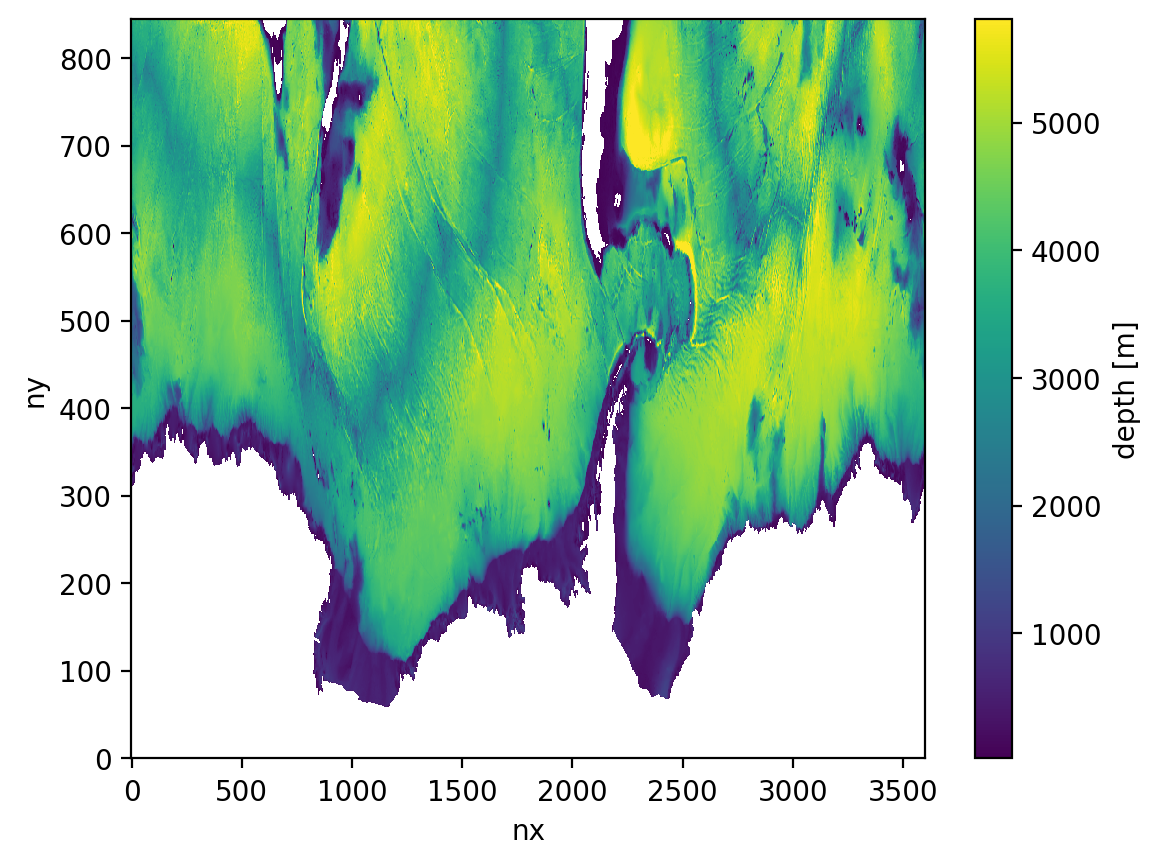

In [257]:
panan_topog_new.depth.plot()

In [268]:
panan_topog_new.depth.attrs['minimum_depth']=float(panan_topog_new.depth.min())

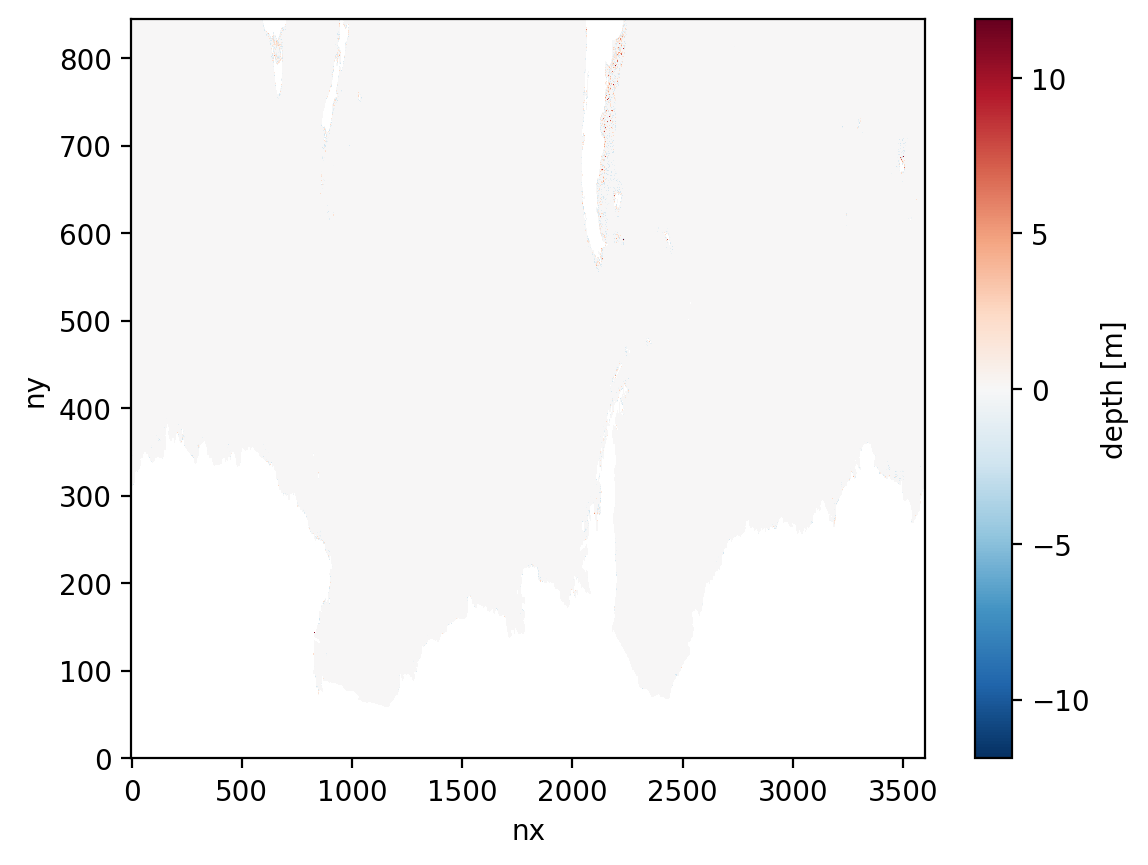

In [271]:
# How does itlook like compared to OM2
(panan_topog_new.depth - OM2_topog.depth.where(OM2_topog.depth>0).isel(ny=slice(0,845))).plot()

Seems very similar to me.... lets save the file

In [272]:
panan_topog_new.to_netcdf(outputdir +"ocean_topog.nc")